## **README**
  
[GVAE] H. Hosoya, “Group-based Learning of Disentangled Representations with Generalizability for Novel Contents,” in Proceedings of the Twenty-Eighth International Joint Conference on Artificial Intelligence, Macao, China, 2019, pp. 2506–2513, doi: 10.24963/ijcai.2019/348.

 
[MLVAE] D. Bouchacourt, R. Tomioka, and S. Nowozin, “Multi-Level Variational Autoencoder: Learning Disentangled Representations from Grouped Observations,” arXiv:1705.08841 [cs, stat], May 2017, Accessed: Feb. 19, 2021. [Online]. Available: http://arxiv.org/abs/1705.08841.
  

In [1]:
# -*- coding: utf-8 -*-
from IPython import display

import os, sys, time, glob, io, pprint, re, shutil
import numpy as np
from sklearn.metrics.pairwise import euclidean_distances

import matplotlib.pyplot as plt
import h5py
import pandas as pd
from datetime import datetime

import tensorflow as tf
tfk = tf.keras
tfkl = tfk.layers
tfkltd = tf.keras.layers.TimeDistributed
from tensorflow.keras.utils import to_categorical

from absl import app, flags

if not sys.version_info[0]==3:
    sys.exit("Python 3 required")

""" specify available GPUs """
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="4,5,6,7"

""" limit GPU memory growth """
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # currently memory growth needs to be same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs", len(logical_gpus), "Logical GPUs\n\n")
    except RuntimeError as e:
        # memory growth must be set before GPUs have been initialized
        print(e)
        
""" clear tensorflow session """
tfk.backend.clear_session()


4 Physical GPUs 4 Logical GPUs




In [2]:
strategy = tf.distribute.MirroredStrategy()
print('num devices = %d'%strategy.num_replicas_in_sync)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
num devices = 4


### Bag MNIST data into instances

In [3]:
NUM_INSTANCES = 21 # number of instances in a bag
NUM_CLASS = 10     # mnist has 10 classes

(trn_images, trn_labels), (tst_images, tst_labels) = tfk.datasets.mnist.load_data()

def rescale_and_flatten_images(images):
    images = images.reshape((images.shape[0], 28*28)) / 255.
    return images.astype('float32')
#     return np.where(images > .5, 1.0, 0.0).astype('float32')

trn_images = rescale_and_flatten_images(trn_images)
tst_images = rescale_and_flatten_images(tst_images)

print(trn_images.shape)
print(tst_images.shape)

(60000, 784)
(10000, 784)


In [4]:
BUFFER_SIZE = trn_images.shape[0]
BATCH_SIZE_PER_REPLICA = 32
GLOBAL_BATCH_SIZE = BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync

NUM_TRAIN=trn_images.shape[0]
MASK_SIZE=10

class MaskedMNISTDataset(tf.data.Dataset):
    def _generator():
        """ Yields a single datapoint which consists of the tuple

            data_replicate = (R[0]data, ..., R[nreplicate]data)
            shifts = 
        """
        for ii in range(NUM_TRAIN):
            img = trn_images[ii,:] # [data_dim]
            img = np.expand_dims(img, axis=0) #[1, data_dim]
            img_instances = np.repeat(img, NUM_INSTANCES, axis=0) #[instances, data_dim]
            
            for kk in range(NUM_INSTANCES):
                tmp = img_instances[kk,:].reshape(28,28)

                mask = np.ones((28,28))
                xx = np.random.randint(28-MASK_SIZE)
                yy = np.random.randint(28-MASK_SIZE)
                
                tmp[xx:(xx+MASK_SIZE), yy:(yy+MASK_SIZE)] = 1.
                img_instances[kk,:] = tmp.flatten()
            
            bagged_masked_img = img_instances
            
#             mask_instances = np.zeros(img_instances.shape)
#             for kk in range(NUM_INSTANCES):
#                 mask = np.ones((28,28))
#                 xx = np.random.randint(28-MASK_SIZE)
#                 yy = np.random.randint(28-MASK_SIZE)
                
#                 mask[xx:(xx+MASK_SIZE), yy:(yy+MASK_SIZE)] = 0.
#                 mask_instances[kk,:] = mask.flatten()
            
#             bagged_masked_img = img_instances*mask_instances
            
            yield bagged_masked_img.astype('float32')
               
    def __new__(self):
        return tf.data.Dataset.from_generator(
            self._generator,
            output_types = (tf.float32),
            output_shapes = (tf.TensorShape([NUM_INSTANCES, 28*28])),            
        )
    
trn_dataset = MaskedMNISTDataset().prefetch(tf.data.experimental.AUTOTUNE)
trn_dataset = trn_dataset.shuffle(NUM_TRAIN)
trn_dataset = trn_dataset.batch(GLOBAL_BATCH_SIZE)

# distributed dataset
trn_dist_dataset = strategy.experimental_distribute_dataset(trn_dataset)

### Define GVAE Model

In [5]:
""" Custom Layers """
class StyleEncoder(tfkl.Layer):
    """ Responsible for encoding the style of each instance.
    
    Maps [?, instances, data_dim] -> [?, instances, sty_dim] (for mean and log-variance)
    """
    def __init__(self, style_dim, mask_rate, name='style_encoder', **kwargs):
        """ initialization """
        super().__init__(name, **kwargs)
        
        self.mask_rate = mask_rate # fraction of entries to mask to zero
        
        """ define dimensions """
        self.style_dim = style_dim
        
        # encoding for each instance
        self.enc_per_instance = tfk.Sequential(
                [   tfkl.Dense(512),
                    tfkl.LeakyReLU(),
                    tfkl.Dense(256),
                    tfkl.LeakyReLU(),
                    tfkl.Dense(style_dim),
                    ],
                    name="enc_per_instance",
                )
                
        self.enc_mean = tfk.Sequential(
                [   tfkl.Dense(style_dim)
                    ],
                    name="z_mean",
                )

#         # use Gaussian approximation to Bernoulli dropout
#         # by moment matching: ~N(u, p/(1-p)* u^2)
#         self.enc_log_var = tfk.Sequential(
#                 [   tfkl.Activation(tf.math.square),
#                     tfkl.Lambda(lambda x: x * mask_rate/(1-mask_rate)),
#                     tfkl.Activation(tf.math.log),
#                     ],
#                     name="z_log_var",
#                 )

    def call(self, inputs):
        X = inputs # [?, instances, data_dim]
        ninstances = inputs.shape[1]
        data_dim = inputs.shape[2]
        
        # reshape instances into sample axis: [?*instances, data_dim]
        inputs =  tfkl.Reshape((-1, data_dim), name='flatten_instances')(inputs)
        # apply encoder to each replicate: [?*instances, style_dim]
        common = self.enc_per_instance(inputs)
        
        z_mean = self.enc_mean(common) # [?*instances, style_dim]
#         z_log_var = self.enc_log_var(common) # [?*instances, style_dim]
        
        # reshape back to [?, instances, style_dim]
        z_mean = tfkl.Reshape((ninstances, self.style_dim))(z_mean)
#         z_log_var = tfkl.Reshape((ninstances, self.style_dim))(z_log_var)
        
#         return z_mean, z_log_var
        return z_mean
    
class ContentEncoder(tfkl.Layer):
    """ Responsible for encoding the content common to each instance.
    
    For GVAE the content encoder N(z|x1,...xk) has the parametric form
    of N( \avg \mu(xi), \avg s(xi), i.e. averaging a common encoder across instances.
    
    Maps [?, instances, data_dim] -> [?, 1, content_dim] (for mean and log-variance)
    """
    def __init__(self, content_dim, name='style_encoder', **kwargs):
        """ initialization """
        super().__init__(name, **kwargs)
        
        """ define dimensions """
        self.content_dim = content_dim
        
        # encoding for each instance
        self.enc_per_instance = tfk.Sequential(
                [   tfkl.Dense(512),
                    tfkl.LeakyReLU(),
                    tfkl.Dense(256),
                    tfkl.LeakyReLU(),
                    tfkl.Dense(content_dim),
                    ],
                    name="enc_per_instance",
                )
                
        self.enc_mean = tfk.Sequential(
                [   tfkl.Dense(content_dim)
                    ],
                    name="z_mean",
                )

        self.enc_log_var = tfk.Sequential(
                [   tfkl.Dense(content_dim, activation=tf.math.softplus)
                    ],
                    name="z_log_var",
                )

    def call(self, inputs):
        X = inputs # [?, instances, data_dim]
        ninstances = inputs.shape[1]
        data_dim = inputs.shape[2]
        
        # reshape instances into sample axis: [?*instances, data_dim]
        inputs =  tfkl.Reshape((-1, data_dim), name='flatten_instances')(inputs)
        # apply encoder to each replicate: [?*instances, content_dim]
        common = self.enc_per_instance(inputs)
        
        z_mean = self.enc_mean(common) # [?*instances, content_dim]
        z_log_var = self.enc_log_var(common) # [?*instances, content_dim]
        
        # reshape back to [?, instances, content_dim]
        z_mean = tfkl.Reshape((ninstances, self.content_dim))(z_mean)
        z_log_var = tfkl.Reshape((ninstances, self.content_dim))(z_log_var)
        
        # compute average to [?, content_dim]
        z_mean = tfkl.GlobalAveragePooling1D()(z_mean)
        z_log_var = tfkl.GlobalAveragePooling1D()(z_log_var)
        
        # [?, content_dim] -> [?, 1, content_dim]
        z_mean = tfkl.Reshape((1, self.content_dim))(z_mean)
        z_log_var = tfkl.Reshape((1, self.content_dim))(z_log_var)
        
        return z_mean, z_log_var

class Decoder(tfkl.Layer):
    """ Decodes each pair of (z_content, z_instance)
    
    The number of instances is automatically inferred at runtime.
    
    Maps [?, instances, latent_dim] -> [?, instances, data_dim]
    """
    def __init__(self, data_dim, dec_var_model='trainable',
            name='decoder', **kwargs):
        super().__init__(name, **kwargs)
        
        self.data_dim = data_dim
        
        self.dec_var_model = dec_var_model

#         trainable = True if dec_var_model=='trainable' else False
        self.dec_var = tf.Variable(
                initial_value= tf.constant(1.0, dtype='float32'),
                name='dec_var',
                trainable= True if dec_var_model=='trainable' else False,
#                 trainable=trainable,
                )
        
        self.dec_per_instance = tfk.Sequential(
            [   tfkl.Dense(256),
                tfkl.LeakyReLU(),
                tfkl.Dense(512),
                tfkl.LeakyReLU(),
                tfkl.Dense(data_dim, activation='sigmoid'),
            ],
            name="dec_per_instance",        
        )

    def call(self, z):
        # infer number of instances [?, instances, latent_dim]
        ninstances = z.shape[1]
        latent_dim = z.shape[2]
        
        # reshape instances to sample axis : [?*instances, latent_dim]
        z = tfkl.Reshape((-1, latent_dim))(z)
        # apply decoding to each instance : [?*instances, data_dim]
        x_mean = self.dec_per_instance(z)
        # collect instances : [?, instances, data_dim]
        x_mean = tfkl.Reshape((ninstances, self.data_dim))(x_mean)
        
        x_var = self.dec_var

        return x_mean, x_var
    
class Sampler(tfkl.Layer):
    """ Samples from Normal with z_mean and z_log_var.

    Returns  (-1, z_mean.shape[0], nsamp)
    """
    def __init__(self, nsamp=1, name='sampler', **kwargs):
        super().__init__(name=name, **kwargs)

        if nsamp > 1:
            raise NotImplementedError

    def call(self, inputs):
        z_mean, z_log_var = inputs
        epsilon = tfk.backend.random_normal(shape=tf.shape(z_mean))

        return z_mean + 0.5*tf.exp(z_log_var)*epsilon
    
class BernoulliSampler(tfkl.Layer):
    """ Use Gaussian Approximation for Bernoulli dropout by moment matching
    
    u \cdot Ber(0,p) ~ N(u, p/(1-p)u^2)
    """
    def __init__(self, mask_rate, nsamp=1, name='sampler', **kwargs):
        super().__init__(name=name, **kwargs)
        
        self.mask_rate = mask_rate # fraction of entries to mask to zero

        if nsamp > 1:
            raise NotImplementedError

    def call(self, z_mean):
        
        epsilon = tfk.backend.random_normal(shape=tf.shape(z_mean))
        
        p = self.mask_rate
        std = tf.math.sqrt(p/(1-p))*tf.math.abs(z_mean)

        return z_mean + std*epsilon

class SYMVAE(tfk.Model):
    """ Grouped Variational Auto-Encoder
    
    [Input]
        X ~ [?, instances, data_dim]
    """
    def __init__(self, data_dim, style_dim, content_dim, mask_rate,
            nsamp=1, name='GVAE', dec_var_model ='trainable', **kwargs):
        """ initialize """
        super().__init__(name=name, **kwargs)
        
        self.mask_rate = mask_rate
        self.dec_var_model = dec_var_model

        """ define dimensions """
        self.data_dim = data_dim
        self.style_dim = style_dim
        self.content_dim = content_dim
        latent_dim = style_dim + content_dim
        self.latent_dim = style_dim + content_dim
                        
        """ build encoder & decoder graphs """
        self.style_encoder = StyleEncoder(style_dim, mask_rate)
        self.content_encoder = ContentEncoder(content_dim)
        self.decoder = Decoder(data_dim, dec_var_model=dec_var_model)
        
        self.sampler = Sampler()
        self.dropout_sampler = BernoulliSampler(mask_rate)

    def call(self, inputs):
        # input = [?, instances, data_dim]
        X = inputs
        ninstances = X.shape[1]
        
        """ evaluate encoder/decoder """        
        # style encoding: [?, instances, data_dim] -> [?, instances, style_dim]
        sty_mean = self.style_encoder(X)
        p = self.mask_rate
        sty_log_var = tf.math.log((p/(1-p))*sty_mean**2)
        
        # content encoding: [?, instances, data_dim] -> [?, 1, content_dim]
        cnt_mean, cnt_log_var = self.content_encoder(X)
        # replicate along instance dimension -> [?, instances, content_dim]
        cnt_mean_replicate = tfkl.UpSampling1D(ninstances, name="replicate")(cnt_mean)
        cnt_log_var_replicate = tfkl.UpSampling1D(ninstances, name="replicate")(cnt_log_var)
        
        # sample
        z_sty = self.dropout_sampler( sty_mean ) # [?, instances, style_dim]
        z_cnt = self.sampler( (cnt_mean_replicate, cnt_log_var_replicate) ) # [?, instances, content_dim]
        
        # concatenate
        z = tfkl.Concatenate(axis=-1)([z_sty, z_cnt])
               
        # decode
        dec_mean, dec_var = self.decoder(z)

        """ compute ELBO loss """
        
        # squared error per example
        se = tf.square(X - dec_mean) # [?, instances, data_dim]
        se_per_instance = tf.reduce_sum(se, axis=-1) # [?, instances]
        se_per_ex = tf.reduce_sum(se_per_instance, axis=-1) #[?, ]
        
        log_llhd_per_ex = (1/dec_var)*se_per_ex + ninstances*tf.math.log(dec_var)
        log_llhd_per_ex = -0.5*log_llhd_per_ex # [?,], we 'max' the ELBO        
        
        sty_KL = -sty_log_var + tf.exp(sty_log_var) + tf.square(sty_mean) # [?, instances, style_dim]
        sty_KL_per_instance = tf.reduce_sum(sty_KL, axis=-1) # [?, instances]
        sty_KL_per_ex = 0.5*tf.reduce_sum(sty_KL_per_instance, axis=-1) # [?, ]
        
        cnt_mean = cnt_mean[:,0,:] #[?, 1, content_dim] -> [?, content_dim]
        cnt_log_var = cnt_log_var[:,0,:] #[?, 1, content_dim] -> [?, content_dim]
        cnt_KL = -cnt_log_var + tf.exp(cnt_log_var) + tf.square(cnt_mean) #[?, content_dim]
        cnt_KL_per_ex = 0.5*tf.reduce_sum(cnt_KL, axis=-1) #[?, ]
        
        ELBO_per_ex = log_llhd_per_ex - sty_KL_per_ex - cnt_KL_per_ex # [?, ]
        
        return ELBO_per_ex, log_llhd_per_ex, sty_KL_per_ex, cnt_KL_per_ex, se_per_ex, dec_mean

    def encode_decode(self, inputs):
        """ Apply VAE deterministically: xhat = dec(enc(x))
        """
        X = inputs
                
        """ evaluate encoder/decoder """        
        # style encoding: [?, instances, data_dim] -> [?, instances, style_dim]
        sty_mean = self.style_encoder(X)
        
        # content encoding: [?, instances, data_dim] -> [?, 1, content_dim]
        cnt_mean, cnt_log_var = self.content_encoder(X)
        # replicate along instance dimension -> [?, instances, content_dim]
        cnt_mean_replicate = tfkl.UpSampling1D(ninstances, name="replicate")(cnt_mean)
   
        # concatenate
        z = tfkl.Concatenate(axis=-1)([sty_mean, cnt_mean_replicate])
               
        # decode
        dec_mean, dec_var = self.decoder(z)

        return dec_mean

    def content_encode(self, X):        
        # content encoding: [?, instances, data_dim] -> [?, 1, content_dim]
        cnt_mean, cnt_log_var = self.content_encoder(X)
        return cnt_mean
    
    def style_encode(self, X):         
        # style encoding: [?, instances, data_dim] -> [?, instances, style_dim]
        sty_mean = self.style_encoder(X)
        return sty_mean
    
    def style_decode(self, cnt_mean, sty_mean):
        ninstances = sty_mean.shape[1]
        # replicate along instance dimension -> [?, instances, content_dim]
        cnt_mean_replicate = tfkl.UpSampling1D(ninstances)(cnt_mean)
   
        # concatenate:  [?, instances, latent_dim]
        z = tfkl.Concatenate(axis=-1)([sty_mean, cnt_mean_replicate])
               
        # decode: [?, instances, data_dim]
        dec_mean, _ = self.decoder(z)
        
        return dec_mean

    def decode(self, z):
        """ Apply decoder to arbitrary input """
        x_dec, x_var = self.decoder(z)

        return x_dec, x_var

### Optimization

In [6]:
with strategy.scope():
    # define model
    style_dim = 20
    content_dim = 20
    data_dim = 28*28
    mask_rate = 0.9
    ninstances = NUM_INSTANCES
    
    symvae = SYMVAE(data_dim, style_dim, content_dim, mask_rate, dec_var_model='fixed')
    
    # setup exponential schedular
    initial_learning_rate = 2e-4
#     initial_learning_rate = 1e-3
    lr_schedule = tfk.optimizers.schedules.ExponentialDecay(
                initial_learning_rate,
                decay_steps=2000,
                decay_rate=0.96,
                staircase=True)

    # opt = tf.optimizers.Adam(learning_rate=5e-4)
    opt = tf.optimizers.Adam(learning_rate=lr_schedule)
    
    # instantiante model again inside strategy scope   
    trn_loss_metric = tfk.metrics.Mean()
    trn_mse_metric = tfk.metrics.Mean()
    trn_sty_KL_metric = tfk.metrics.Mean()
    trn_cnt_KL_metric = tfk.metrics.Mean()

@tf.function
def train_step(inputs):
    with tf.GradientTape() as tape:
        # call model: returns losses per each example, i.e. shape [?,]
        elbo_per_ex, log_llhd_per_ex, sty_KL_per_ex, cnt_KL_per_ex, mse_per_ex, x_mean = symvae(inputs)

        # compute average loss using batch size
        elbo = tf.nn.compute_average_loss(elbo_per_ex, global_batch_size=GLOBAL_BATCH_SIZE)
        loss = -elbo
        
    # track metrics
    trn_loss_metric(-elbo_per_ex)
    trn_mse_metric(mse_per_ex)
    trn_sty_KL_metric(sty_KL_per_ex)
    trn_cnt_KL_metric(cnt_KL_per_ex)
    
    # apply gradients
    grads = tape.gradient(loss, symvae.trainable_weights)
    opt.apply_gradients(zip(grads, symvae.trainable_weights))
    
    return loss

# `run` replicates the provided computation and runs it
# with the distributed input.
@tf.function
def distributed_train_step(dataset_inputs):
    per_replica_losses = strategy.run(train_step, args=(dataset_inputs,))
    return 


Start of epoch 0
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INF

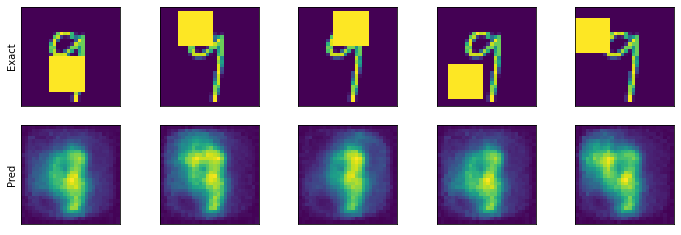

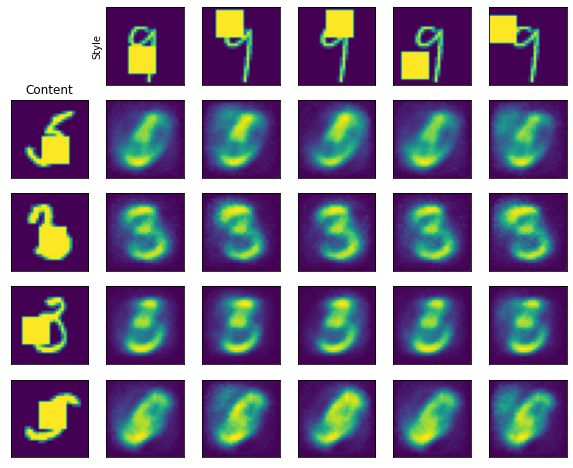

	mean loss    = 1839.441
	mse          = 1.765e+03
	KL           = 9.272e+02
	KL           = 2.995e+01
	dec_var      = 1.000e+00
epoch = 65.58s
Start of epoch 1
	mean loss    = 2555.718
	mse          = 1.490e+03
	KL           = 1.783e+03
	KL           = 2.755e+01
	dec_var      = 1.000e+00
epoch = 44.95s
Start of epoch 2
	mean loss    = 4220.441
	mse          = 1.432e+03
	KL           = 3.476e+03
	KL           = 2.830e+01
	dec_var      = 1.000e+00
epoch = 44.14s
Start of epoch 3
	mean loss    = 2274.015
	mse          = 1.344e+03
	KL           = 1.575e+03
	KL           = 2.691e+01
	dec_var      = 1.000e+00
epoch = 45.31s
Start of epoch 4
	mean loss    = 2524.339
	mse          = 1.346e+03
	KL           = 1.823e+03
	KL           = 2.821e+01
	dec_var      = 1.000e+00
epoch = 44.20s
Start of epoch 5
=== TRN ===


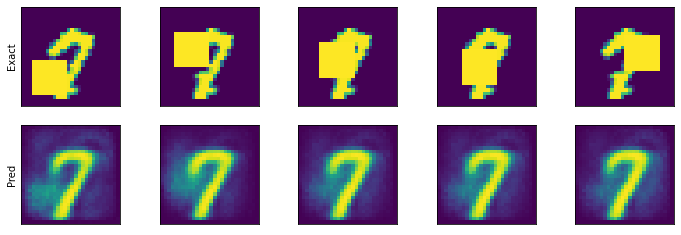

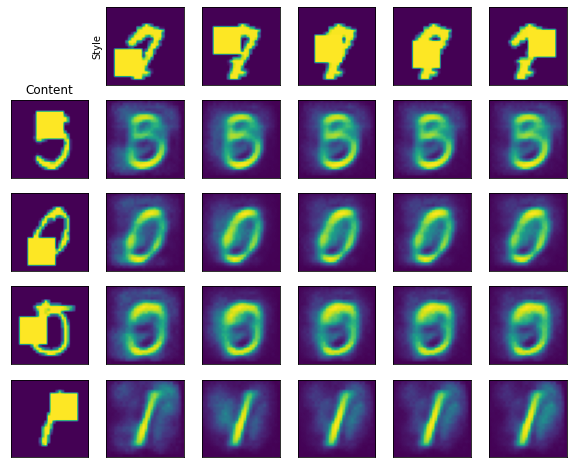

	mean loss    = 2472.827
	mse          = 1.338e+03
	KL           = 1.775e+03
	KL           = 2.899e+01
	dec_var      = 1.000e+00
epoch = 46.52s
Start of epoch 6
	mean loss    = 1518.528
	mse          = 1.280e+03
	KL           = 8.501e+02
	KL           = 2.852e+01
	dec_var      = 1.000e+00
epoch = 44.79s
Start of epoch 7
	mean loss    = 1460.900
	mse          = 1.253e+03
	KL           = 8.051e+02
	KL           = 2.923e+01
	dec_var      = 1.000e+00
epoch = 44.16s
Start of epoch 8
	mean loss    = 1453.716
	mse          = 1.254e+03
	KL           = 7.975e+02
	KL           = 2.944e+01
	dec_var      = 1.000e+00
epoch = 44.45s
Start of epoch 9
	mean loss    = 1483.107
	mse          = 1.287e+03
	KL           = 8.094e+02
	KL           = 3.036e+01
	dec_var      = 1.000e+00
epoch = 44.19s
Start of epoch 10
=== TRN ===


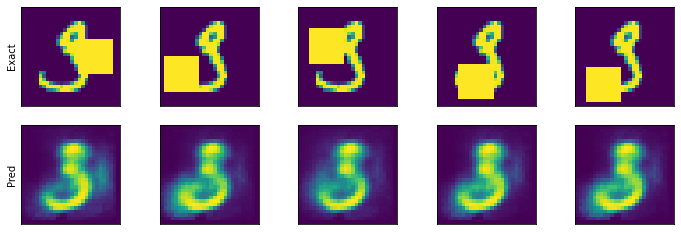

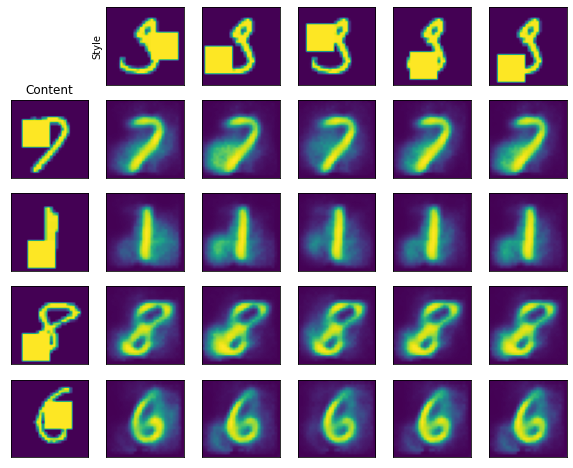

	mean loss    = 1311.358
	mse          = 1.242e+03
	KL           = 6.609e+02
	KL           = 2.962e+01
	dec_var      = 1.000e+00
epoch = 45.45s
Start of epoch 11
	mean loss    = 1333.792
	mse          = 1.215e+03
	KL           = 6.962e+02
	KL           = 3.023e+01
	dec_var      = 1.000e+00
epoch = 44.18s
Start of epoch 12
	mean loss    = 1922.872
	mse          = 1.260e+03
	KL           = 1.262e+03
	KL           = 3.127e+01
	dec_var      = 1.000e+00
epoch = 44.46s
Start of epoch 13
	mean loss    = 2603.274
	mse          = 1.274e+03
	KL           = 1.935e+03
	KL           = 3.142e+01
	dec_var      = 1.000e+00
epoch = 44.90s
Start of epoch 14
	mean loss    = 2792.972
	mse          = 1.233e+03
	KL           = 2.145e+03
	KL           = 3.108e+01
	dec_var      = 1.000e+00
epoch = 44.85s
Start of epoch 15
=== TRN ===


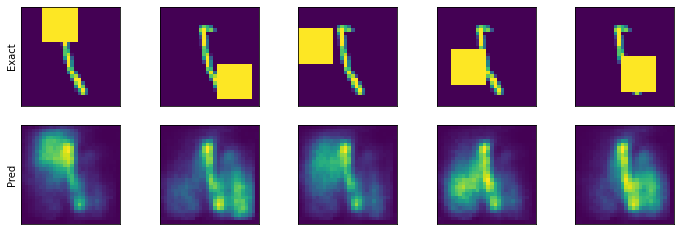

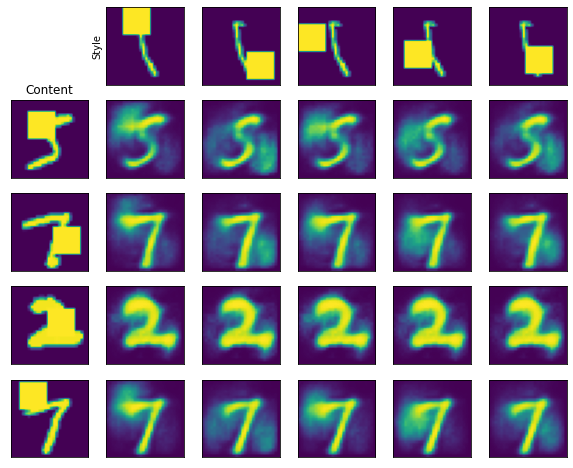

	mean loss    = 1530.346
	mse          = 1.175e+03
	KL           = 9.125e+02
	KL           = 3.024e+01
	dec_var      = 1.000e+00
epoch = 46.48s
Start of epoch 16
	mean loss    = 1697.257
	mse          = 1.193e+03
	KL           = 1.070e+03
	KL           = 3.142e+01
	dec_var      = 1.000e+00
epoch = 43.96s
Start of epoch 17
	mean loss    = 1640.779
	mse          = 1.161e+03
	KL           = 1.029e+03
	KL           = 3.086e+01
	dec_var      = 1.000e+00
epoch = 44.85s
Start of epoch 18
	mean loss    = 1505.994
	mse          = 1.161e+03
	KL           = 8.944e+02
	KL           = 3.107e+01
	dec_var      = 1.000e+00
epoch = 44.44s
Start of epoch 19
	mean loss    = 1557.826
	mse          = 1.147e+03
	KL           = 9.533e+02
	KL           = 3.099e+01
	dec_var      = 1.000e+00
epoch = 44.46s
Start of epoch 20
=== TRN ===


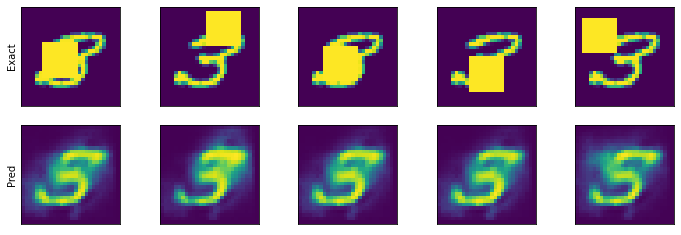

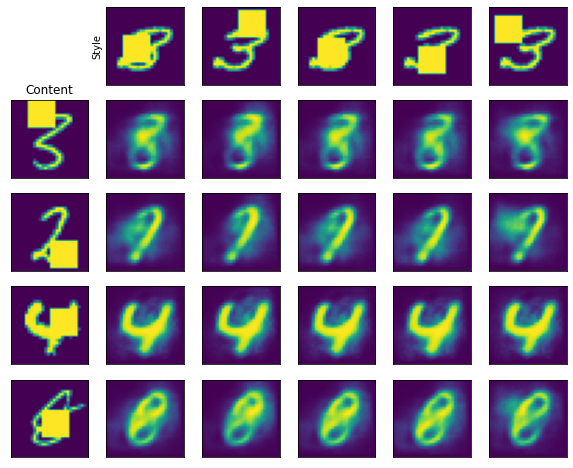

	mean loss    = 1360.268
	mse          = 1.126e+03
	KL           = 7.663e+02
	KL           = 3.111e+01
	dec_var      = 1.000e+00
epoch = 46.55s
Start of epoch 21
	mean loss    = 1333.995
	mse          = 1.144e+03
	KL           = 7.308e+02
	KL           = 3.113e+01
	dec_var      = 1.000e+00
epoch = 44.58s
Start of epoch 22
	mean loss    = 1508.015
	mse          = 1.194e+03
	KL           = 8.798e+02
	KL           = 3.141e+01
	dec_var      = 1.000e+00
epoch = 43.99s
Start of epoch 23
	mean loss    = 1455.128
	mse          = 1.185e+03
	KL           = 8.313e+02
	KL           = 3.159e+01
	dec_var      = 1.000e+00
epoch = 44.68s
Start of epoch 24
	mean loss    = 1368.550
	mse          = 1.186e+03
	KL           = 7.442e+02
	KL           = 3.112e+01
	dec_var      = 1.000e+00
epoch = 44.52s
Start of epoch 25
=== TRN ===


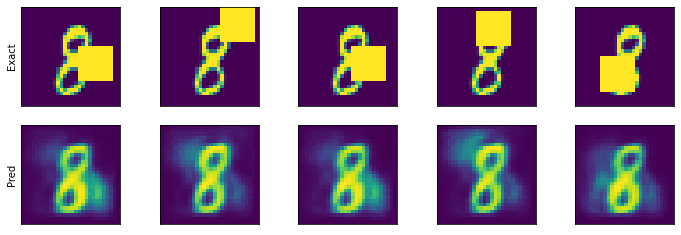

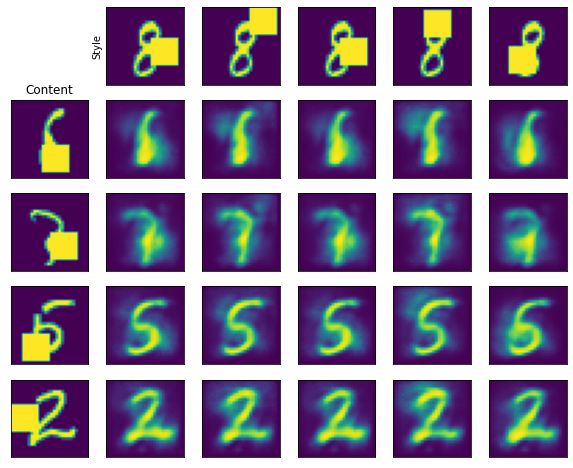

	mean loss    = 2032.217
	mse          = 1.237e+03
	KL           = 1.381e+03
	KL           = 3.237e+01
	dec_var      = 1.000e+00
epoch = 46.05s
Start of epoch 26
	mean loss    = 1511.224
	mse          = 1.145e+03
	KL           = 9.073e+02
	KL           = 3.155e+01
	dec_var      = 1.000e+00
epoch = 44.45s
Start of epoch 27
	mean loss    = 1509.729
	mse          = 1.165e+03
	KL           = 8.955e+02
	KL           = 3.172e+01
	dec_var      = 1.000e+00
epoch = 44.46s
Start of epoch 28
	mean loss    = 3424.234
	mse          = 1.215e+03
	KL           = 2.785e+03
	KL           = 3.176e+01
	dec_var      = 1.000e+00
epoch = 45.22s
Start of epoch 29
	mean loss    = 1768.005
	mse          = 1.159e+03
	KL           = 1.157e+03
	KL           = 3.168e+01
	dec_var      = 1.000e+00
epoch = 45.14s
Start of epoch 30
=== TRN ===


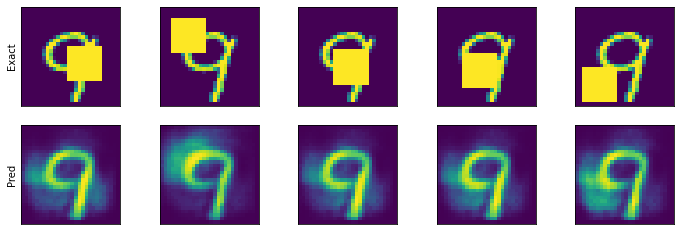

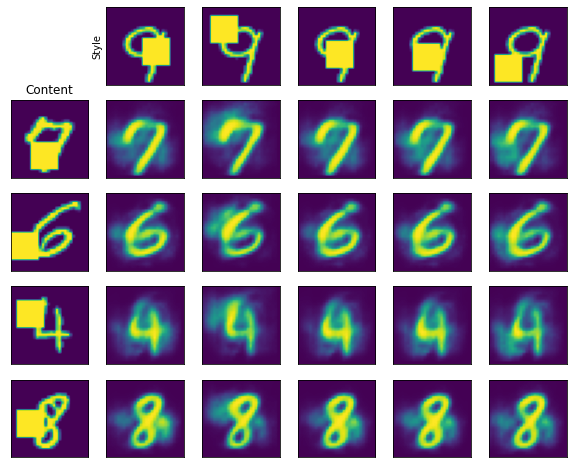

	mean loss    = 1538.033
	mse          = 1.134e+03
	KL           = 9.393e+02
	KL           = 3.190e+01
	dec_var      = 1.000e+00
epoch = 46.71s
Start of epoch 31
	mean loss    = 1700.821
	mse          = 1.178e+03
	KL           = 1.080e+03
	KL           = 3.205e+01
	dec_var      = 1.000e+00
epoch = 44.66s
Start of epoch 32
	mean loss    = 1864.479
	mse          = 1.164e+03
	KL           = 1.250e+03
	KL           = 3.214e+01
	dec_var      = 1.000e+00
epoch = 44.87s
Start of epoch 33
	mean loss    = 2606.351
	mse          = 1.195e+03
	KL           = 1.977e+03
	KL           = 3.249e+01
	dec_var      = 1.000e+00
epoch = 44.62s
Start of epoch 34
	mean loss    = 2109.140
	mse          = 1.126e+03
	KL           = 1.514e+03
	KL           = 3.192e+01
	dec_var      = 1.000e+00
epoch = 44.26s
Start of epoch 35
=== TRN ===


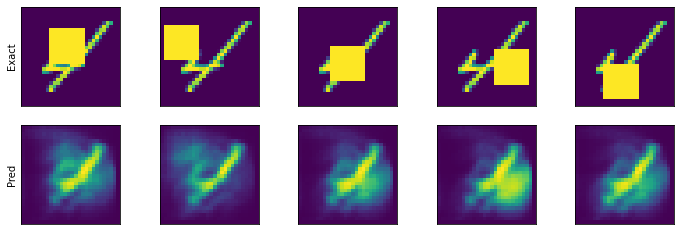

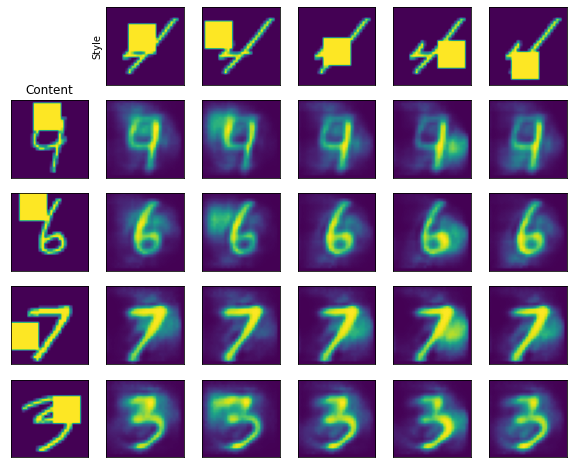

	mean loss    = 1768.789
	mse          = 1.113e+03
	KL           = 1.181e+03
	KL           = 3.198e+01
	dec_var      = 1.000e+00
epoch = 46.71s
Start of epoch 36
	mean loss    = 1542.448
	mse          = 1.072e+03
	KL           = 9.742e+02
	KL           = 3.211e+01
	dec_var      = 1.000e+00
epoch = 45.75s
Start of epoch 37
	mean loss    = 1396.648
	mse          = 1.093e+03
	KL           = 8.179e+02
	KL           = 3.241e+01
	dec_var      = 1.000e+00
epoch = 44.62s
Start of epoch 38
	mean loss    = 1366.834
	mse          = 1.105e+03
	KL           = 7.817e+02
	KL           = 3.250e+01
	dec_var      = 1.000e+00
epoch = 44.28s
Start of epoch 39
	mean loss    = 1700.587
	mse          = 1.111e+03
	KL           = 1.113e+03
	KL           = 3.242e+01
	dec_var      = 1.000e+00
epoch = 44.66s
Start of epoch 40
=== TRN ===


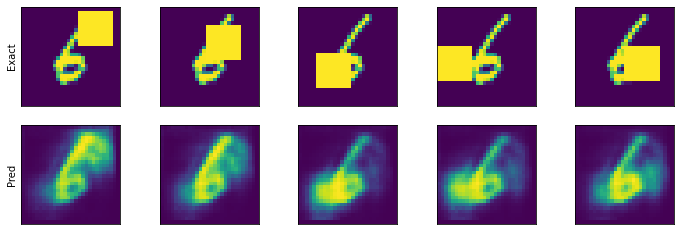

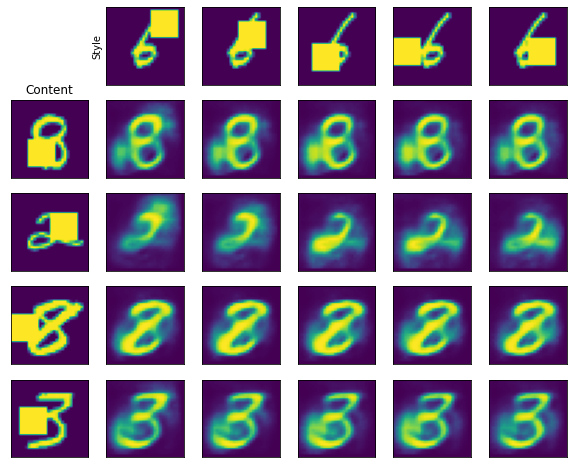

	mean loss    = 1428.061
	mse          = 1.106e+03
	KL           = 8.429e+02
	KL           = 3.207e+01
	dec_var      = 1.000e+00
epoch = 48.13s
Start of epoch 41
	mean loss    = 1327.784
	mse          = 1.079e+03
	KL           = 7.557e+02
	KL           = 3.241e+01
	dec_var      = 1.000e+00
epoch = 46.25s
Start of epoch 42
	mean loss    = 1345.935
	mse          = 1.111e+03
	KL           = 7.583e+02
	KL           = 3.221e+01
	dec_var      = 1.000e+00
epoch = 45.58s
Start of epoch 43
	mean loss    = 1894.044
	mse          = 1.190e+03
	KL           = 1.267e+03
	KL           = 3.265e+01
	dec_var      = 1.000e+00
epoch = 45.83s
Start of epoch 44
	mean loss    = 1329.858
	mse          = 1.087e+03
	KL           = 7.539e+02
	KL           = 3.225e+01
	dec_var      = 1.000e+00
epoch = 44.85s
Start of epoch 45
=== TRN ===


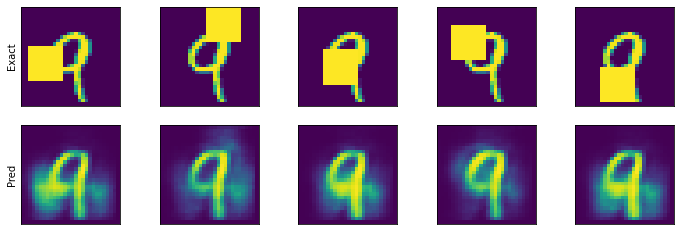

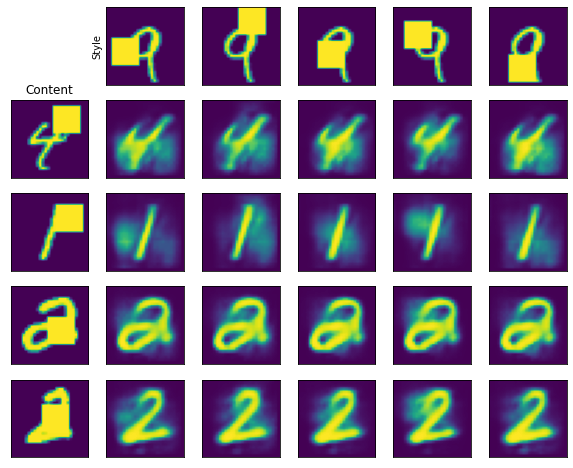

	mean loss    = 1233.523
	mse          = 1.078e+03
	KL           = 6.620e+02
	KL           = 3.249e+01
	dec_var      = 1.000e+00
epoch = 46.50s
Start of epoch 46
	mean loss    = 1539.713
	mse          = 1.124e+03
	KL           = 9.447e+02
	KL           = 3.308e+01
	dec_var      = 1.000e+00
epoch = 43.40s
Start of epoch 47
	mean loss    = 1490.683
	mse          = 1.070e+03
	KL           = 9.231e+02
	KL           = 3.244e+01
	dec_var      = 1.000e+00
epoch = 44.62s
Start of epoch 48
	mean loss    = 2352.940
	mse          = 1.165e+03
	KL           = 1.737e+03
	KL           = 3.310e+01
	dec_var      = 1.000e+00
epoch = 44.37s
Start of epoch 49
	mean loss    = 1541.520
	mse          = 1.081e+03
	KL           = 9.687e+02
	KL           = 3.231e+01
	dec_var      = 1.000e+00
epoch = 44.47s
Start of epoch 50
=== TRN ===


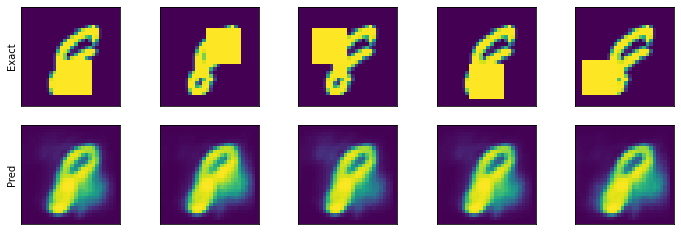

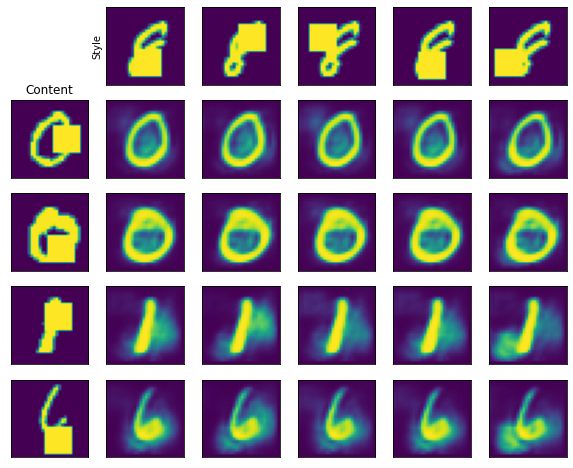

	mean loss    = 1402.068
	mse          = 1.122e+03
	KL           = 8.082e+02
	KL           = 3.275e+01
	dec_var      = 1.000e+00
epoch = 46.47s
Start of epoch 51
	mean loss    = 1569.831
	mse          = 1.134e+03
	KL           = 9.701e+02
	KL           = 3.283e+01
	dec_var      = 1.000e+00
epoch = 44.25s
Start of epoch 52
	mean loss    = 1302.214
	mse          = 1.131e+03
	KL           = 7.038e+02
	KL           = 3.289e+01
	dec_var      = 1.000e+00
epoch = 43.79s
Start of epoch 53
	mean loss    = 1195.856
	mse          = 1.097e+03
	KL           = 6.145e+02
	KL           = 3.291e+01
	dec_var      = 1.000e+00
epoch = 45.16s
Start of epoch 54
	mean loss    = 1165.442
	mse          = 1.092e+03
	KL           = 5.866e+02
	KL           = 3.273e+01
	dec_var      = 1.000e+00
epoch = 43.39s
Start of epoch 55
=== TRN ===


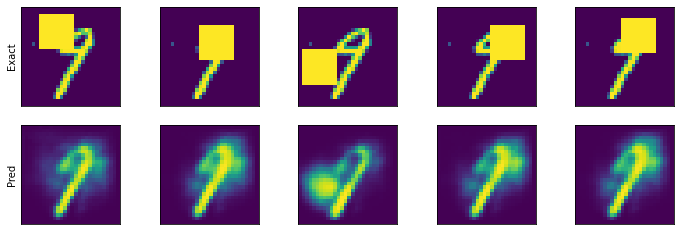

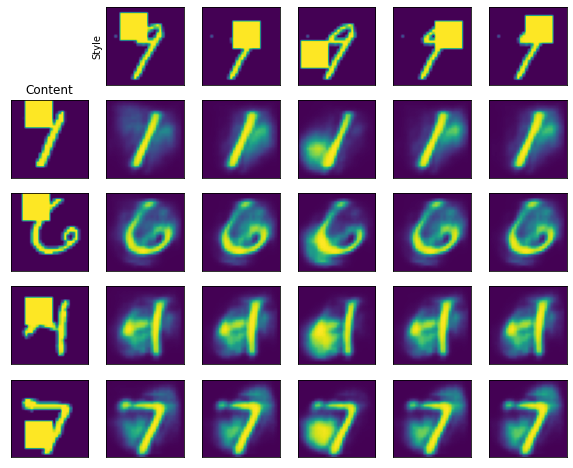

	mean loss    = 1465.885
	mse          = 1.139e+03
	KL           = 8.632e+02
	KL           = 3.324e+01
	dec_var      = 1.000e+00
epoch = 46.96s
Start of epoch 56
	mean loss    = 1488.695
	mse          = 1.110e+03
	KL           = 9.004e+02
	KL           = 3.313e+01
	dec_var      = 1.000e+00
epoch = 44.65s
Start of epoch 57
	mean loss    = 1236.442
	mse          = 1.081e+03
	KL           = 6.627e+02
	KL           = 3.300e+01
	dec_var      = 1.000e+00
epoch = 44.11s
Start of epoch 58
	mean loss    = 1211.965
	mse          = 1.105e+03
	KL           = 6.264e+02
	KL           = 3.289e+01
	dec_var      = 1.000e+00
epoch = 44.49s
Start of epoch 59
	mean loss    = 1298.140
	mse          = 1.161e+03
	KL           = 6.844e+02
	KL           = 3.347e+01
	dec_var      = 1.000e+00
epoch = 43.72s
Start of epoch 60
=== TRN ===


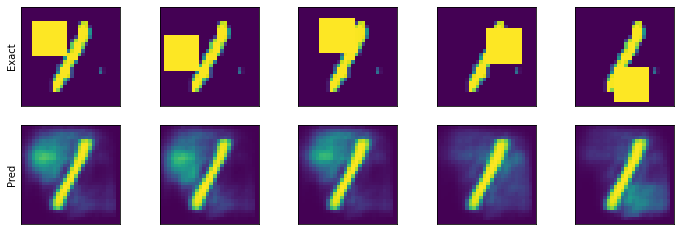

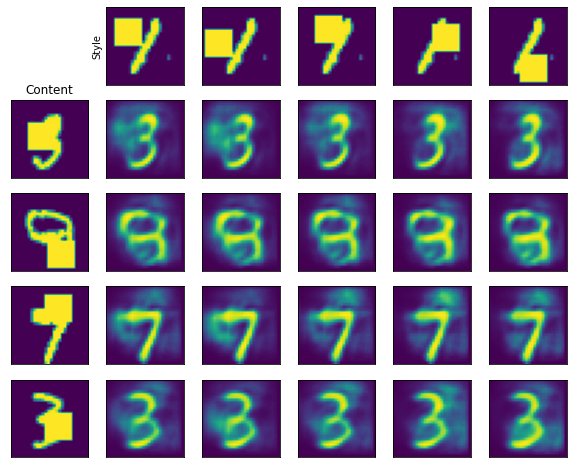

	mean loss    = 1522.325
	mse          = 1.170e+03
	KL           = 9.043e+02
	KL           = 3.317e+01
	dec_var      = 1.000e+00
epoch = 46.58s
Start of epoch 61
	mean loss    = 1227.689
	mse          = 1.103e+03
	KL           = 6.429e+02
	KL           = 3.329e+01
	dec_var      = 1.000e+00
epoch = 43.72s
Start of epoch 62
	mean loss    = 1291.360
	mse          = 1.130e+03
	KL           = 6.928e+02
	KL           = 3.337e+01
	dec_var      = 1.000e+00
epoch = 44.05s
Start of epoch 63
	mean loss    = 1508.772
	mse          = 1.151e+03
	KL           = 9.001e+02
	KL           = 3.314e+01
	dec_var      = 1.000e+00
epoch = 44.31s
Start of epoch 64
	mean loss    = 1294.493
	mse          = 1.124e+03
	KL           = 6.998e+02
	KL           = 3.281e+01
	dec_var      = 1.000e+00
epoch = 44.73s
Start of epoch 65
=== TRN ===


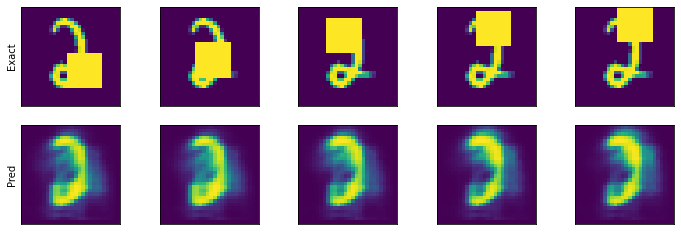

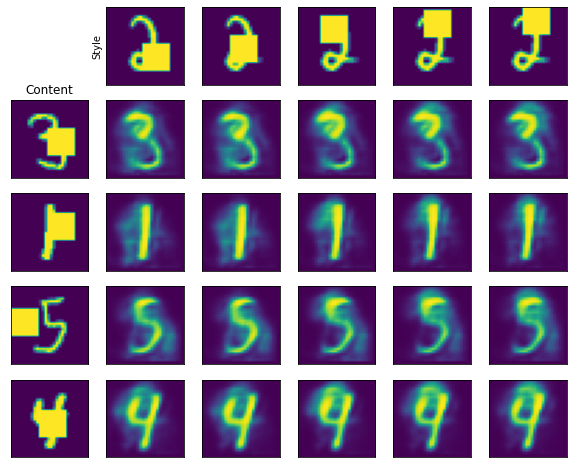

	mean loss    = 1192.683
	mse          = 1.105e+03
	KL           = 6.068e+02
	KL           = 3.332e+01
	dec_var      = 1.000e+00
epoch = 46.50s
Start of epoch 66
	mean loss    = 1146.215
	mse          = 1.068e+03
	KL           = 5.792e+02
	KL           = 3.287e+01
	dec_var      = 1.000e+00
epoch = 45.69s
Start of epoch 67
	mean loss    = 1225.474
	mse          = 1.071e+03
	KL           = 6.566e+02
	KL           = 3.332e+01
	dec_var      = 1.000e+00
epoch = 44.42s
Start of epoch 68
	mean loss    = nan
	mse          = nan
	KL           = nan
	KL           = nan
	dec_var      = 1.000e+00
epoch = 44.90s
Start of epoch 69
	mean loss    = nan
	mse          = nan
	KL           = nan
	KL           = nan
	dec_var      = 1.000e+00
epoch = 43.94s
Start of epoch 70
=== TRN ===


/math/home/mtcli/software/anaconda2/envs/tf2.3/lib/python3.8/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/math/home/mtcli/software/anaconda2/envs/tf2.3/lib/python3.8/site-packages/matplotlib/image.py:453: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/math/home/mtcli/software/anaconda2/envs/tf2.3/lib/python3.8/site-packages/matplotlib/image.py:458: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
/math/home/mtcli/software/anaconda2/envs/tf2.3/lib/python3.8/site-packages/matplotlib/image.py:477: UserWarning: Warning: converting a masked element to nan.
  vrange = np.array([self.norm.vmin, self.norm.vmax],


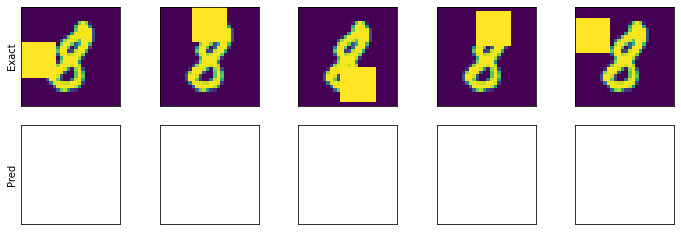

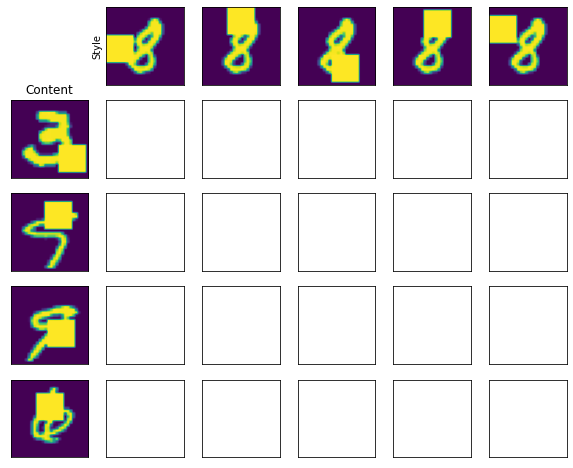

	mean loss    = nan
	mse          = nan
	KL           = nan
	KL           = nan
	dec_var      = 1.000e+00
epoch = 46.71s
Start of epoch 71
	mean loss    = nan
	mse          = nan
	KL           = nan
	KL           = nan
	dec_var      = 1.000e+00
epoch = 44.21s
Start of epoch 72
	mean loss    = nan
	mse          = nan
	KL           = nan
	KL           = nan
	dec_var      = 1.000e+00
epoch = 44.33s
Start of epoch 73
	mean loss    = nan
	mse          = nan
	KL           = nan
	KL           = nan
	dec_var      = 1.000e+00
epoch = 43.87s
Start of epoch 74
	mean loss    = nan
	mse          = nan
	KL           = nan
	KL           = nan
	dec_var      = 1.000e+00
epoch = 44.07s
Start of epoch 75
=== TRN ===


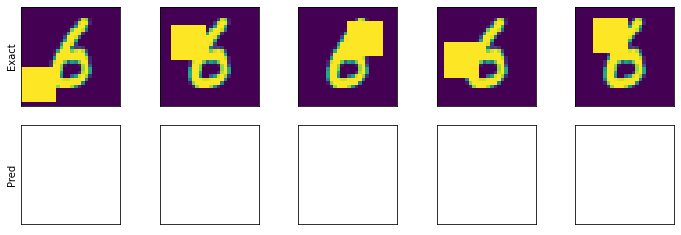

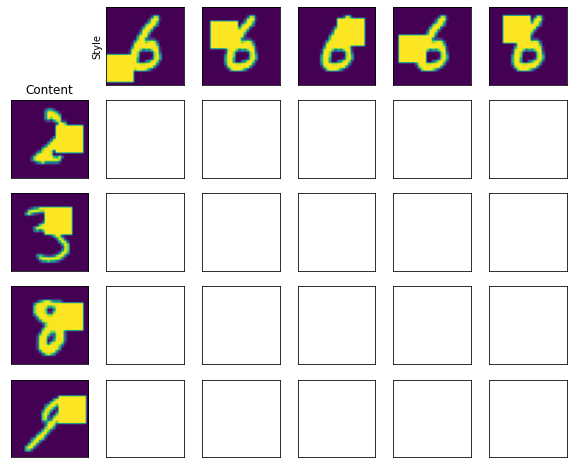

	mean loss    = nan
	mse          = nan
	KL           = nan
	KL           = nan
	dec_var      = 1.000e+00
epoch = 45.87s
Start of epoch 76
	mean loss    = nan
	mse          = nan
	KL           = nan
	KL           = nan
	dec_var      = 1.000e+00
epoch = 44.07s
Start of epoch 77
	mean loss    = nan
	mse          = nan
	KL           = nan
	KL           = nan
	dec_var      = 1.000e+00
epoch = 44.10s
Start of epoch 78
	mean loss    = nan
	mse          = nan
	KL           = nan
	KL           = nan
	dec_var      = 1.000e+00
epoch = 44.72s
Start of epoch 79
	mean loss    = nan
	mse          = nan
	KL           = nan
	KL           = nan
	dec_var      = 1.000e+00
epoch = 45.23s
Start of epoch 80
=== TRN ===


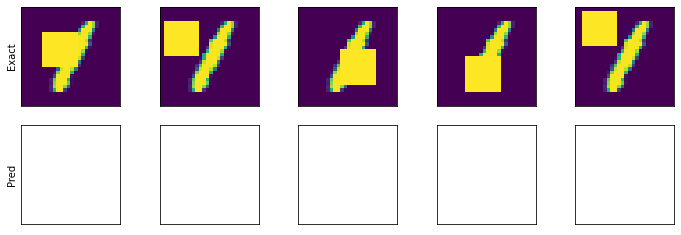

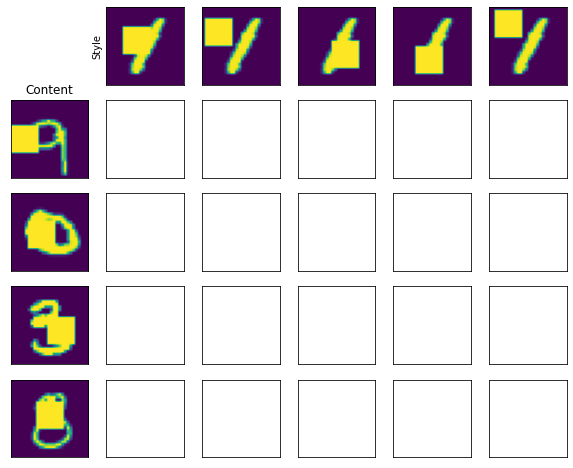

	mean loss    = nan
	mse          = nan
	KL           = nan
	KL           = nan
	dec_var      = 1.000e+00
epoch = 46.78s
Start of epoch 81
	mean loss    = nan
	mse          = nan
	KL           = nan
	KL           = nan
	dec_var      = 1.000e+00
epoch = 43.96s
Start of epoch 82
	mean loss    = nan
	mse          = nan
	KL           = nan
	KL           = nan
	dec_var      = 1.000e+00
epoch = 44.31s
Start of epoch 83
	mean loss    = nan
	mse          = nan
	KL           = nan
	KL           = nan
	dec_var      = 1.000e+00
epoch = 44.39s
Start of epoch 84
	mean loss    = nan
	mse          = nan
	KL           = nan
	KL           = nan
	dec_var      = 1.000e+00
epoch = 44.22s
Start of epoch 85
=== TRN ===


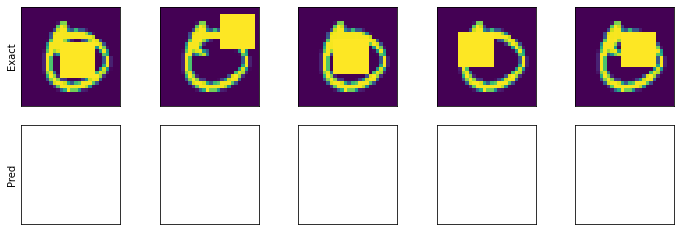

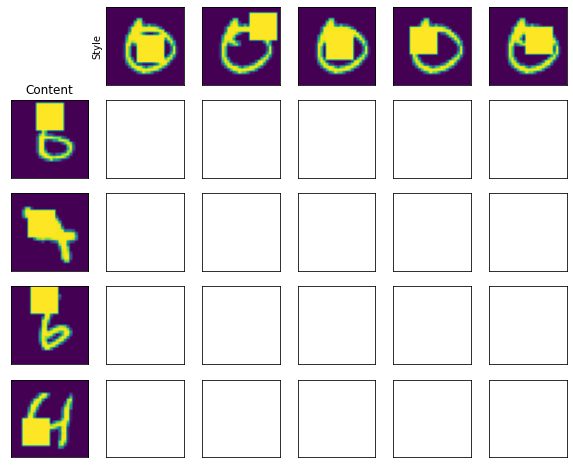

	mean loss    = nan
	mse          = nan
	KL           = nan
	KL           = nan
	dec_var      = 1.000e+00
epoch = 46.41s
Start of epoch 86
	mean loss    = nan
	mse          = nan
	KL           = nan
	KL           = nan
	dec_var      = 1.000e+00
epoch = 45.26s
Start of epoch 87
	mean loss    = nan
	mse          = nan
	KL           = nan
	KL           = nan
	dec_var      = 1.000e+00
epoch = 44.49s
Start of epoch 88
	mean loss    = nan
	mse          = nan
	KL           = nan
	KL           = nan
	dec_var      = 1.000e+00
epoch = 43.97s
Start of epoch 89
	mean loss    = nan
	mse          = nan
	KL           = nan
	KL           = nan
	dec_var      = 1.000e+00
epoch = 44.10s
Start of epoch 90
=== TRN ===


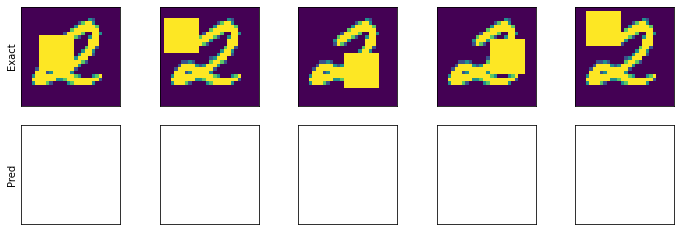

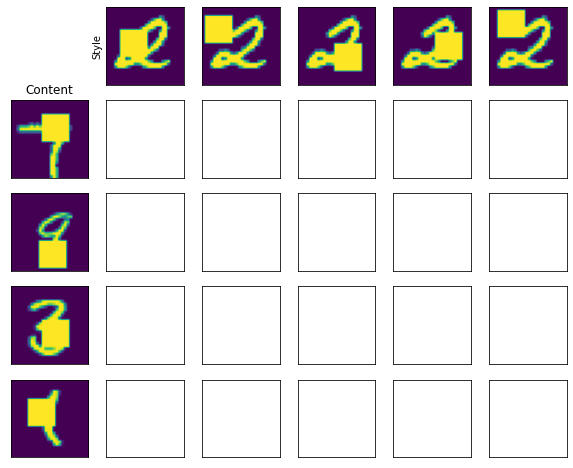

	mean loss    = nan
	mse          = nan
	KL           = nan
	KL           = nan
	dec_var      = 1.000e+00
epoch = 46.51s
Start of epoch 91
	mean loss    = nan
	mse          = nan
	KL           = nan
	KL           = nan
	dec_var      = 1.000e+00
epoch = 46.05s
Start of epoch 92
	mean loss    = nan
	mse          = nan
	KL           = nan
	KL           = nan
	dec_var      = 1.000e+00
epoch = 45.25s
Start of epoch 93
	mean loss    = nan
	mse          = nan
	KL           = nan
	KL           = nan
	dec_var      = 1.000e+00
epoch = 45.94s
Start of epoch 94
	mean loss    = nan
	mse          = nan
	KL           = nan
	KL           = nan
	dec_var      = 1.000e+00
epoch = 46.52s
Start of epoch 95
=== TRN ===


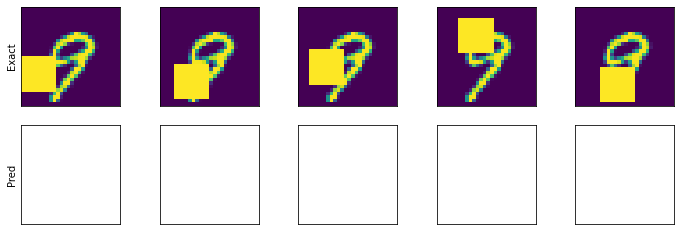

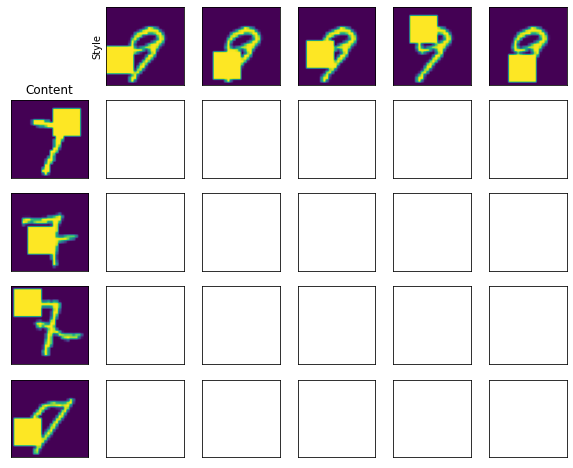

	mean loss    = nan
	mse          = nan
	KL           = nan
	KL           = nan
	dec_var      = 1.000e+00
epoch = 48.50s
Start of epoch 96
	mean loss    = nan
	mse          = nan
	KL           = nan
	KL           = nan
	dec_var      = 1.000e+00
epoch = 45.35s
Start of epoch 97
	mean loss    = nan
	mse          = nan
	KL           = nan
	KL           = nan
	dec_var      = 1.000e+00
epoch = 45.50s
Start of epoch 98
	mean loss    = nan
	mse          = nan
	KL           = nan
	KL           = nan
	dec_var      = 1.000e+00
epoch = 46.04s
Start of epoch 99
	mean loss    = nan
	mse          = nan
	KL           = nan
	KL           = nan
	dec_var      = 1.000e+00
epoch = 45.19s
Start of epoch 100
=== TRN ===


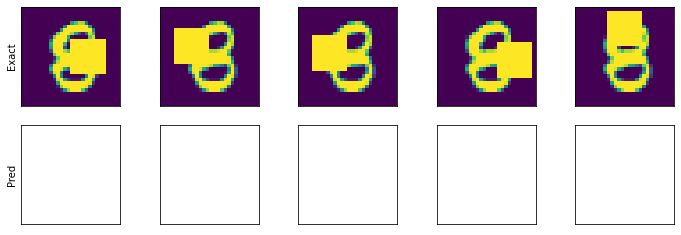

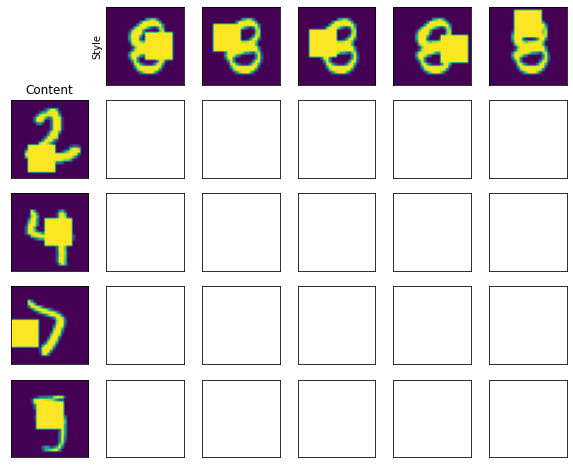

	mean loss    = nan
	mse          = nan
	KL           = nan
	KL           = nan
	dec_var      = 1.000e+00
epoch = 46.94s


In [7]:
# Iterate over epochs.
num_epochs = 101

for epoch in range(num_epochs):
#     display.clear_output(wait=False)
    print('===================', flush=True)
    print('Start of epoch %d' % (epoch,))
    start_time = time.perf_counter()
         
    for step, trn_batch in enumerate(trn_dist_dataset):
        _ = distributed_train_step(trn_batch)
            
    if epoch % 5 == 0:
        print('=== TRN ===')
#         if strategy.num_replicas_in_sync > 1:
#             # grab only batch assigned to first GPU
#             trn_batch = [x.values[0].numpy() for x in trn_batch]
#         else:
#             trn_batch = [x.numpy() for x in trn_batch]
#         trn_batch = [x.numpy() for x in trn_batch]
#         trn_batch = trn_batch.numpy()

        trn_batch = trn_batch.values[0].numpy()
        """ plot decoding of replicates """
        pred = symvae.encode_decode(trn_batch)
#         se = (pred - trn_batch[0])**2 # squared error
        
        pred = pred.numpy()
        
        plt.figure(figsize=(12,4), facecolor='w')
        num_instance_plot = min([5, NUM_INSTANCES])
        for kk in np.arange(num_instance_plot):
            plt.subplot(2, num_instance_plot, kk+1)
            plt.imshow(trn_batch[0,kk,:].reshape(28,28))
            plt.xticks([]); plt.yticks([]);
            if kk == 0:
                plt.ylabel('Exact')
                    
            plt.subplot(2, num_instance_plot, num_instance_plot+kk+1)
            plt.imshow(pred[0,kk,:].reshape(28,28))
            plt.xticks([]); plt.yticks([]);
            if kk == 0:
                plt.ylabel('Pred')
            
        plt.show()
        
        """ plot styling of replicates """
        nsplot = 5 # number of style plots

        content_code = symvae.content_encode(trn_batch).numpy()
        style_code = symvae.style_encode(trn_batch).numpy()
        
        plt.figure(figsize=(10,10), facecolor='w')
        for jj in np.arange(nsplot):
            styled_mean = symvae.style_decode(content_code[[jj],:,:], style_code[[0],:,:])
            styled_mean = styled_mean.numpy()
            for kk in np.arange(nsplot):
                if jj == 0:
                    # plot the style of each instance inside the 0th bag
                    plt.subplot(nsplot+1, nsplot+1, kk+2)
                    plt.imshow(trn_batch[0,kk,:].reshape(28,28))
                    plt.xticks([]); plt.yticks([]);
                    if kk==0:
                        plt.ylabel('Style')
                else:
                    if kk==0:
                        # plot an instance to show the "content"
                        plt.subplot(nsplot+1, nsplot+1, jj*(nsplot+1)+kk+1)
                        plt.imshow(trn_batch[jj,0,:].reshape(28,28))
                        plt.xticks([]); plt.yticks([]);
                        if jj == 1:
                            plt.title('Content')

                    # style the jth bag with styles from the 0th bag
                    plt.subplot(nsplot+1, nsplot+1, jj*(nsplot+1)+kk+2)
                    plt.imshow(styled_mean[0,kk,:].reshape(28,28))
                    plt.xticks([]); plt.yticks([]);
                    
        plt.show()
    
    print('\tmean loss    = %.3f' % trn_loss_metric.result().numpy())
    print('\tmse          = %.3e' % trn_mse_metric.result().numpy())
    print('\tKL           = %.3e' % trn_sty_KL_metric.result().numpy())
    print('\tKL           = %.3e' % trn_cnt_KL_metric.result().numpy())
    print('\tdec_var      = %.3e' % symvae.decoder.dec_var.numpy())
    trn_loss_metric.reset_states()
    trn_mse_metric.reset_states()
    trn_sty_KL_metric.reset_states()
    trn_cnt_KL_metric.reset_states()
    
    print('epoch = %.2fs' % (time.perf_counter()-start_time))

In [8]:
# # https://www.tensorflow.org/guide/keras/save_and_serialize#hdf5_format
# gvae.save_weights('symvae-masked-mnist-p0_9.h5')